# Forecast Uncertainty Cascades: From Prediction to Prescription

This notebook demonstrates how **forecast uncertainty cascades through the system**: forecast errors become parameter errors, which become recommendation errors.

Understanding this is critical because:
- Forecasts have uncertainty (they're predictions, not facts)
- Forecast uncertainty becomes parameter uncertainty
- Parameter uncertainty becomes recommendation uncertainty
- Poor forecasts lead to poor recommendations, even with perfect optimization


## Key Concepts

**Forecasts** provide future predictions:
- Demand forecasts, cost projections, trend predictions
- These become parameters in prescriptive models
- But forecasts are predictions, not certainties

**The Cascade Effect**:
- Forecast uncertainty → Parameter uncertainty → Recommendation uncertainty
- If forecast predicts 1,000 units but actual is 800, that's a 20% error
- The model uses 1,000 as a parameter, so the recommendation is wrong
- This happens regardless of optimization quality

**Forecast Quality Matters**:
- Good forecasts lead to good recommendations
- Poor forecasts lead to poor recommendations
- Even perfect optimization can't fix bad forecasts

**Critical insight**: Forecast errors become recommendation errors. Understanding this cascade helps you assess recommendation risk.


## Scenario: Inventory Ordering with Demand Forecast

You manage inventory for a product. A predictive model forecasts demand for next month.

**The forecast says**: 1,000 units (but could be 800-1,200)

**The prescriptive model uses this forecast** as a parameter to recommend ordering 1,200 units (to maintain safety stock).

**But what if the forecast is wrong?** How does forecast error affect the recommendation?


## Step 1: Import Libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


## Step 2: Forecast with Uncertainty

Let's start with a forecast that has uncertainty:


DEMAND FORECAST (from Predictive Model):
  Forecast: 1000 units
  Range: 800 to 1200 units
  Uncertainty: ±200.0 units (±20%)

⚠️  WARNING: Forecasts have uncertainty - they're predictions, not facts!


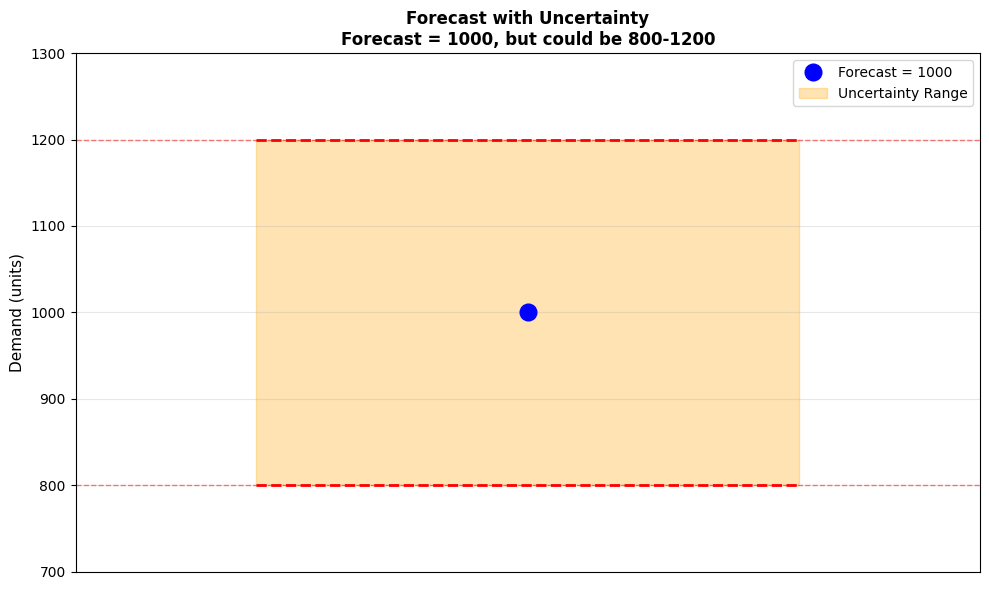

In [2]:
# Forecast from predictive model
forecast_demand = 1000  # Predicted demand
forecast_lower = 800    # Lower bound (could be this low)
forecast_upper = 1200   # Upper bound (could be this high)
forecast_range = forecast_upper - forecast_lower

print("DEMAND FORECAST (from Predictive Model):")
print(f"  Forecast: {forecast_demand} units")
print(f"  Range: {forecast_lower} to {forecast_upper} units")
print(f"  Uncertainty: ±{forecast_range/2} units (±{forecast_range/2/forecast_demand*100:.0f}%)")
print("\n⚠️  WARNING: Forecasts have uncertainty - they're predictions, not facts!")

# Visualize forecast uncertainty
fig, ax = plt.subplots(figsize=(10, 6))

# Forecast point
ax.plot([0], [forecast_demand], 'o', color='blue', markersize=12, 
        label=f'Forecast = {forecast_demand}', zorder=3)

# Uncertainty range
ax.fill_between([-0.3, 0.3], forecast_lower, forecast_upper, 
                alpha=0.3, color='orange', label='Uncertainty Range')
ax.plot([-0.3, 0.3], [forecast_lower, forecast_lower], '--', color='red', linewidth=2)
ax.plot([-0.3, 0.3], [forecast_upper, forecast_upper], '--', color='red', linewidth=2)

ax.axhline(y=forecast_lower, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax.axhline(y=forecast_upper, color='red', linestyle='--', linewidth=1, alpha=0.5)

ax.set_xlim(-0.5, 0.5)
ax.set_ylim(700, 1300)
ax.set_ylabel('Demand (units)', fontsize=11)
ax.set_title('Forecast with Uncertainty\nForecast = 1000, but could be 800-1200', 
             fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3, axis='y')
ax.set_xticks([])

plt.tight_layout()
plt.show()


## Step 3: Forecast Becomes Parameter

The prescriptive model uses the forecast as a parameter. Notice how forecast uncertainty becomes parameter uncertainty:


In [3]:
# Prescriptive model uses forecast as parameter
safety_stock_pct = 0.20  # 20% safety stock

# Model recommendation using forecast
order_quantity = forecast_demand * (1 + safety_stock_pct)

print("FORECAST → PARAMETER → RECOMMENDATION:")
print(f"\n1. FORECAST (from predictive model):")
print(f"   {forecast_demand} units (uncertainty: {forecast_lower}-{forecast_upper})")
print(f"\n2. PARAMETER (used in prescriptive model):")
print(f"   Demand = {forecast_demand} units")
print(f"   ⚠️  Model assumes forecast is accurate (ignores uncertainty!)")
print(f"\n3. RECOMMENDATION (from prescriptive model):")
print(f"   Order {order_quantity:.0f} units")
print(f"   (Forecast {forecast_demand} + 20% safety stock)")

print("\n\nKEY INSIGHT:")
print("  Forecast uncertainty → Parameter uncertainty → Recommendation uncertainty")
print("  If forecast is wrong, parameter is wrong, recommendation is wrong!")


FORECAST → PARAMETER → RECOMMENDATION:

1. FORECAST (from predictive model):
   1000 units (uncertainty: 800-1200)

2. PARAMETER (used in prescriptive model):
   Demand = 1000 units
   ⚠️  Model assumes forecast is accurate (ignores uncertainty!)

3. RECOMMENDATION (from prescriptive model):
   Order 1200 units
   (Forecast 1000 + 20% safety stock)


KEY INSIGHT:
  Forecast uncertainty → Parameter uncertainty → Recommendation uncertainty
  If forecast is wrong, parameter is wrong, recommendation is wrong!


## Step 4: What Happens When Forecast is Wrong?

Let's see what happens when actual demand differs from the forecast:


In [4]:
# Test different actual demand scenarios
actual_demand_scenarios = {
    'Forecast Accurate': forecast_demand,
    'Forecast Too High': 800,  # 20% lower than forecast
    'Forecast Too Low': 1200,  # 20% higher than forecast
    'Forecast Way Off': 600    # 40% lower than forecast
}

results = []

for scenario_name, actual_demand in actual_demand_scenarios.items():
    # Forecast error
    forecast_error = actual_demand - forecast_demand
    forecast_error_pct = (forecast_error / forecast_demand) * 100
    
    # Model used forecast as parameter, so recommendation is based on forecast
    model_order = order_quantity  # Model's recommendation
    
    # What actually happens
    inventory_after_demand = model_order - actual_demand
    
    # Problems
    if inventory_after_demand < 0:
        stockout = abs(inventory_after_demand)
        overstock = 0
        problem = f"Stockout: {stockout:.0f} units short"
    else:
        stockout = 0
        overstock = inventory_after_demand
        problem = f"Overstock: {overstock:.0f} units excess"
    
    results.append({
        'Scenario': scenario_name,
        'Forecast': forecast_demand,
        'Actual': actual_demand,
        'Forecast Error %': f"{forecast_error_pct:+.0f}%",
        'Model Order': model_order,
        'Problem': problem
    })

results_df = pd.DataFrame(results)
print("FORECAST ERROR → RECOMMENDATION ERROR:\n")
print(results_df.to_string(index=False))

print("\n\nKEY OBSERVATIONS:")
print("  - When forecast is accurate: Recommendation works")
print("  - When forecast is too high: Overstock (ordered too much)")
print("  - When forecast is too low: Stockout (ordered too little)")
print("  - Forecast errors become recommendation errors!")


FORECAST ERROR → RECOMMENDATION ERROR:

         Scenario  Forecast  Actual Forecast Error %  Model Order                     Problem
Forecast Accurate      1000    1000              +0%       1200.0 Overstock: 200 units excess
Forecast Too High      1000     800             -20%       1200.0 Overstock: 400 units excess
 Forecast Too Low      1000    1200             +20%       1200.0   Overstock: 0 units excess
 Forecast Way Off      1000     600             -40%       1200.0 Overstock: 600 units excess


KEY OBSERVATIONS:
  - When forecast is accurate: Recommendation works
  - When forecast is too high: Overstock (ordered too much)
  - When forecast is too low: Stockout (ordered too little)
  - Forecast errors become recommendation errors!


## Step 5: Visualize the Cascade Effect

Let's visualize how uncertainty cascades from forecast to recommendation:


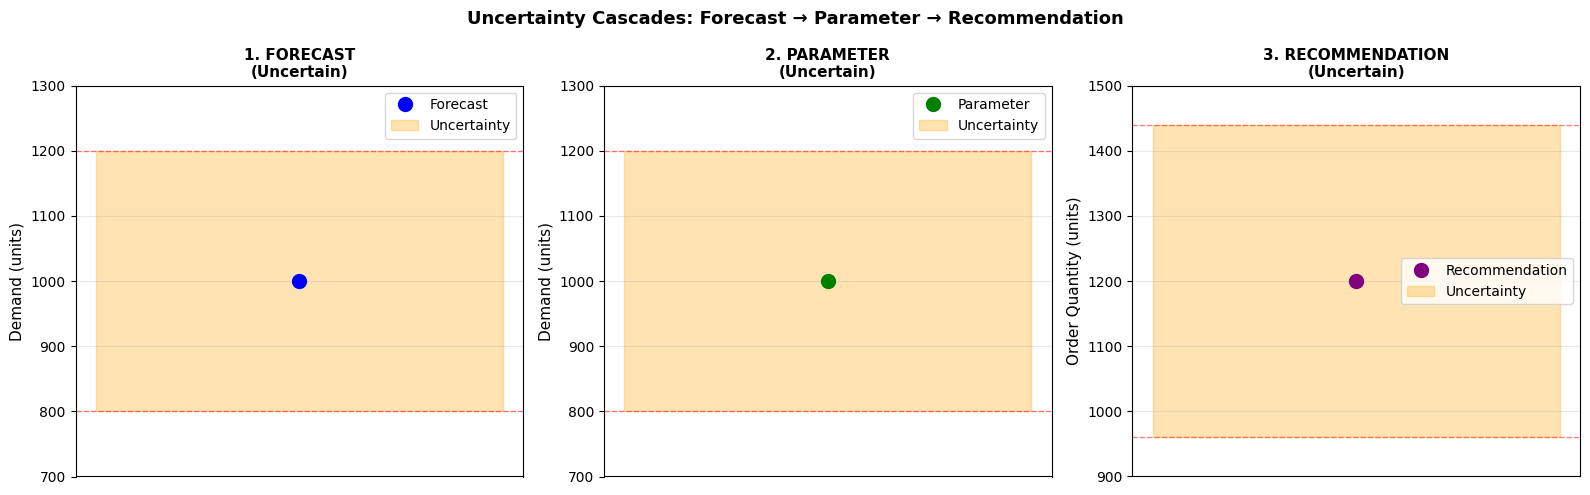


KEY INSIGHT:
  Charts 1 and 2 show the *same* demand (800–1200) on purpose: the parameter
  is just the forecast plugged into the model—no new info, so uncertainty
  doesn't narrow. It then propagates and widens in the recommendation (chart 3).
  Forecast uncertainty → Parameter uncertainty → Recommendation uncertainty


In [5]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Plot 1: Forecast with uncertainty
ax1 = axes[0]
ax1.plot([0], [forecast_demand], 'o', color='blue', markersize=10, label='Forecast')
ax1.fill_between([-0.2, 0.2], forecast_lower, forecast_upper, 
                 alpha=0.3, color='orange', label='Uncertainty')
ax1.axhline(y=forecast_lower, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax1.axhline(y=forecast_upper, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax1.set_ylim(700, 1300)
ax1.set_ylabel('Demand (units)', fontsize=11)
ax1.set_title('1. FORECAST\n(Uncertain)', fontsize=11, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3, axis='y')
ax1.set_xticks([])

# Plot 2: Parameter (model uses forecast)
ax2 = axes[1]
ax2.plot([0], [forecast_demand], 'o', color='green', markersize=10, label='Parameter')
ax2.fill_between([-0.2, 0.2], forecast_lower, forecast_upper, 
                 alpha=0.3, color='orange', label='Uncertainty')
ax2.axhline(y=forecast_lower, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax2.axhline(y=forecast_upper, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax2.set_ylim(700, 1300)
ax2.set_ylabel('Demand (units)', fontsize=11)
ax2.set_title('2. PARAMETER\n(Uncertain)', fontsize=11, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3, axis='y')
ax2.set_xticks([])

# Plot 3: Recommendation (based on parameter)
ax3 = axes[2]
rec_lower = forecast_lower * (1 + safety_stock_pct)
rec_upper = forecast_upper * (1 + safety_stock_pct)
ax3.plot([0], [order_quantity], 'o', color='purple', markersize=10, label='Recommendation')
ax3.fill_between([-0.2, 0.2], rec_lower, rec_upper, 
                 alpha=0.3, color='orange', label='Uncertainty')
ax3.axhline(y=rec_lower, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax3.axhline(y=rec_upper, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax3.set_ylim(900, 1500)
ax3.set_ylabel('Order Quantity (units)', fontsize=11)
ax3.set_title('3. RECOMMENDATION\n(Uncertain)', fontsize=11, fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3, axis='y')
ax3.set_xticks([])

plt.suptitle('Uncertainty Cascades: Forecast → Parameter → Recommendation', 
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nKEY INSIGHT:")
print("  Charts 1 and 2 show the *same* demand (800–1200) on purpose: the parameter")
print("  is just the forecast plugged into the model—no new info, so uncertainty")
print("  doesn't narrow. It then propagates and widens in the recommendation (chart 3).")
print("  Forecast uncertainty → Parameter uncertainty → Recommendation uncertainty")


In [6]:
# Compare forecast quality
actual_demand = 1000  # True demand (unknown when making decision)

forecast_scenarios = {
    'Good Forecast': {'forecast': 980, 'error_pct': -2, 'uncertainty': 50},
    'Medium Forecast': {'forecast': 1000, 'error_pct': 0, 'uncertainty': 200},
    'Poor Forecast': {'forecast': 1200, 'error_pct': 20, 'uncertainty': 400}
}

comparison_results = []

for scenario_name, scenario_data in forecast_scenarios.items():
    forecast = scenario_data['forecast']
    uncertainty = scenario_data['uncertainty']
    
    # Model recommendation
    model_order = forecast * (1 + safety_stock_pct)
    
    # What happens
    inventory_after = model_order - actual_demand
    
    if inventory_after < 0:
        problem = f"Stockout: {abs(inventory_after):.0f} units"
        severity = "High"
    elif inventory_after > 200:
        problem = f"Overstock: {inventory_after:.0f} units"
        severity = "High"
    else:
        problem = "OK"
        severity = "Low"
    
    comparison_results.append({
        'Forecast Quality': scenario_name,
        'Forecast': forecast,
        'Uncertainty': f"±{uncertainty}",
        'Model Order': f"{model_order:.0f}",
        'Result': problem,
        'Severity': severity
    })

comparison_df = pd.DataFrame(comparison_results)
print("FORECAST QUALITY → RECOMMENDATION QUALITY:\n")
print(comparison_df.to_string(index=False))

print("\n\nKEY INSIGHT:")
print("  Good forecasts → Good recommendations")
print("  Poor forecasts → Poor recommendations")
print("  Even perfect optimization can't fix bad forecasts!")
print("  Forecast quality = Recommendation quality")


FORECAST QUALITY → RECOMMENDATION QUALITY:

Forecast Quality  Forecast Uncertainty Model Order               Result Severity
   Good Forecast       980         ±50        1176                   OK      Low
 Medium Forecast      1000        ±200        1200                   OK      Low
   Poor Forecast      1200        ±400        1440 Overstock: 440 units     High


KEY INSIGHT:
  Good forecasts → Good recommendations
  Poor forecasts → Poor recommendations
  Even perfect optimization can't fix bad forecasts!
  Forecast quality = Recommendation quality


## Summary: Forecast Uncertainty Cascades

**Key Takeaways:**

1. **Forecasts have uncertainty**
   - They're predictions, not certainties
   - Every forecast has error (the question is how much)
   - Forecast uncertainty becomes parameter uncertainty

2. **Uncertainty cascades through the system**
   - Forecast uncertainty → Parameter uncertainty → Recommendation uncertainty
   - Errors at any step become errors in recommendations
   - Understanding this cascade helps assess recommendation risk

3. **Forecast quality matters**
   - Good forecasts lead to good recommendations
   - Poor forecasts lead to poor recommendations
   - Even perfect optimization can't fix bad forecasts

4. **Forecast errors become recommendation errors**
   - If forecast is too high → Overstock
   - If forecast is too low → Stockout
   - Small forecast errors can cause large recommendation errors

5. **Practical implications**
   - Invest in forecast quality (it's as important as optimization)
   - Test what happens if forecasts are wrong
   - Build robustness into recommendations
   - Understand forecast uncertainty when using forecasts as parameters

**Remember**: Forecast errors become recommendation errors. Forecast quality directly affects recommendation quality!
